In [ ]:
import numpy as np

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def cross_entropy_loss(predictions, labels,reg_lambda):
    predictions = np.clip(predictions, 1e-9, 1 - 1e-9)
    m = labels.shape[0]
    log_probs = -np.log(predictions[np.arange(m), labels])
    loss = np.sum(log_probs) / m
    return loss

def to_categorical(y, num_classes):
    """ Convert vector of labels to one-hot encoding """
    return np.eye(num_classes)[y]

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, activate_model=relu, activation_derivative=relu_derivative):
        self.params = {
            'W1': np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size),
            'b1': np.zeros(hidden_size),
            'W2': np.random.randn(hidden_size, hidden_size) * np.sqrt(2. / hidden_size),
            'b2': np.zeros(hidden_size),
            'W3': np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size),
            'b3': np.zeros(output_size)
        }
        self.activate_model = activate_model
        self.activation_derivative = activation_derivative
    
    def forward(self, X):
        self.cache = {}
        # Layer 1
        self.cache['Z1'] = np.dot(X, self.params['W1']) + self.params['b1']
        self.cache['A1'] = self.activate_model(self.cache['Z1'])
        # Layer 2
        self.cache['Z2'] = np.dot(self.cache['A1'], self.params['W2']) + self.params['b2']
        self.cache['A2'] = self.activate_model(self.cache['Z2'])
        # Layer 3
        self.cache['Z3'] = np.dot(self.cache['A2'], self.params['W3']) + self.params['b3']
        self.cache['A3'] = softmax(self.cache['Z3'])
        return self.cache['A3']
    
    def backward(self, X, y):
        m = X.shape[0]
        y_true = to_categorical(y, self.params['W3'].shape[1])

        # Gradient for Layer 3
        dZ3 = self.cache['A3'] - y_true
        dW3 = np.dot(self.cache['A2'].T, dZ3) / m
        db3 = np.sum(dZ3, axis=0) / m

        # Gradient for Layer 2
        dA2 = np.dot(dZ3, self.params['W3'].T)
        dZ2 = dA2 * self.activation_derivative(self.cache['Z2'])
        dW2 = np.dot(self.cache['A1'].T, dZ2) / m
        db2 = np.sum(dZ2, axis=0) / m

        # Gradient for Layer 1
        dA1 = np.dot(dZ2, self.params['W2'].T)
        dZ1 = dA1 * self.activation_derivative(self.cache['Z1'])
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0) / m

        gradients = {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2, 'W3': dW3, 'b3': db3}
        return gradients

    def update_params(self, gradients, lr, reg_lambda):
        for key in self.params:
            self.params[key] -= lr * (gradients[key] + reg_lambda * self.params[key])



In [ ]:
def evaluate_model(model, X, y):

    predictions = model.forward(X)
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = np.mean(predicted_labels == y)
    m = y.shape[0]
    y_one_hot = np.eye(model.params['W2'].shape[1])[y]  
    log_probs = -np.log(predictions[np.arange(m), y] + 1e-9)  
    loss = np.sum(log_probs) / m

    return accuracy, loss

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
def train(X_train, y_train, X_val, y_val, model, epochs, batch_size, lr, reg_lambda):
    n_batches = int(np.ceil(X_train.shape[0] / batch_size))
    best_val_acc = 0
    best_params = {}
    train_losses = []
    val_accuracys=[]
    val_losses=[]
    for epoch in tqdm(range(epochs)):
        # Shuffle dataset
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]
        epoch_losses = []
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, X_train.shape[0])
            
            X_batch = X_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]
            # Forward and backward propagation
            output = model.forward(X_batch)
            loss=cross_entropy_loss(output,y_batch,reg_lambda)
            epoch_losses.append(loss)
            gradients = model.backward(X_batch, y_batch)
            
            # Update weights
            model.update_params(gradients, lr,reg_lambda)
        average_loss = np.mean(epoch_losses)
        train_losses.append(average_loss)
        # Validation accuracy
        val_acc,val_loss=evaluate_model(model,X_val,y_val)
        print(f'Epoch {epoch + 1}, Train Loss: {average_loss:.4f}')
        print(f'Epoch {epoch + 1}, Validation Accuracy: {val_acc:.4f}')
        val_accuracys.append(val_acc)
        val_losses.append(val_loss)
        # Check if we need to update the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = model.params.copy()
    print(f'Epoch {epoch + 1}, Best Validation Accuracy: {best_val_acc:.4f}')
    
    model.params = best_params
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracys)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.show()

    return model


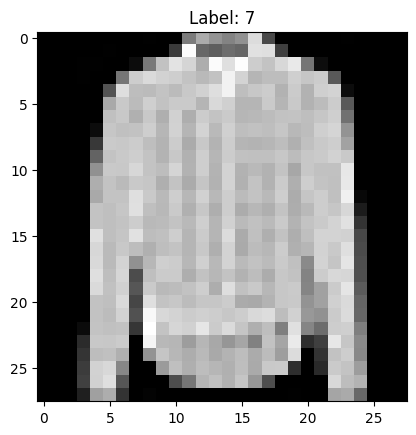

((48000, 784), (12000, 784), (10000, 784))

<Figure size 640x480 with 0 Axes>

In [28]:
import numpy as np
import os
import struct
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte')

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels
train_images, train_labels = load_mnist('data', kind='train')
test_images, test_labels = load_mnist('data', kind='t10k')
train_images, train_labels = load_mnist('data', kind='train')

num_validation_samples = int(0.2 * train_images.shape[0])

indices = np.arange(train_images.shape[0])
np.random.shuffle(indices)

train_images = train_images[indices]
train_labels = train_labels[indices]

val_images = train_images[:num_validation_samples]
val_labels = train_labels[:num_validation_samples]

train_images = train_images[num_validation_samples:]
train_labels = train_labels[num_validation_samples:]
import matplotlib.pyplot as plt

plt.imshow(train_images[0].reshape(28, 28), cmap='gray')
plt.title(f'Label: {train_labels[1]}')
plt.show()

train_images.shape,val_images.shape,test_images.shape

In [ ]:

def grid_search(X_train, y_train, X_val, y_val, input_size, output_size):
    learning_rates = [0.0001,0.00005]
    hidden_sizes = [100, 150,200]
    reg_lambdas = [0.1,0.2]
    batch_sizes=[32,64]
    best_val_acc = 0
    best_params = {}
    results = []

# 参数搜索
    for lr in learning_rates:
        for hidden_size in hidden_sizes:
            for reg_lambda in reg_lambdas:
                for batch_size in batch_sizes:
                    model = NeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
                    print(f"Training with lr={lr}, hidden_size={hidden_size}, reg_lambda={reg_lambda}, batch_size={batch_size}")
                    train(X_train, y_train, X_val, y_val, model, epochs=30, batch_size=batch_size, lr=lr, reg_lambda=reg_lambda)
                    val_acc, _ = evaluate_model(model, X_val, y_val)
                    results.append((lr, hidden_size, reg_lambda, batch_size, val_acc))
                    print(f"Validation accuracy: {val_acc:.4f}")
                    if val_acc > best_val_acc:
                        best_val_acc = val_acc
                        best_params = {'lr': lr, 'hidden_size': hidden_size, 'reg_lambda': reg_lambda, 'batch_size': batch_size}
                        print(f"New best params found: {best_params}, val_acc: {val_acc:.4f}")

    # 保存或返回结果
    return best_params, best_val_acc, results


In [ ]:
best_params, best_accuracy,result=grid_search(train_images,train_labels,val_images, val_labels, input_size=784, output_size=10)
print("result:",result)
print("Best params:", best_params)
print("Best validation accuracy:", best_accuracy)

In [ ]:
model=NeuralNetwork(input_size=784,hidden_size=200,output_size=10)
train(train_images,train_labels,test_images,test_labels,model,epochs=100,batch_size=32,lr=0.0001,reg_lambda=0.2)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix

predictions = model.forward(test_images)

predicted_labels = np.argmax(predictions, axis=1)

accuracy = accuracy_score(test_labels, predicted_labels)

precision = precision_score(test_labels, predicted_labels, average='macro')

f1 = f1_score(test_labels, predicted_labels, average='macro')

conf_matrix = confusion_matrix(test_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print(conf_matrix)

In [ ]:
import pickle
with open('model_params.pkl', 'wb') as f:
    pickle.dump(model.params, f)

with open('model_params.pkl', 'rb') as f:
    loaded_params = pickle.load(f)